<a href="https://colab.research.google.com/github/sourabhx003/ObjectDetection/blob/main/MainObjectDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from google.colab import drive
import os
import zipfile
import csv
import re
from PIL import Image

In [ ]:
!git clone https://github.com/tensorflow/models/
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Cloning into 'models'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 51207 (delta 16), reused 34 (delta 7), pack-reused 51157
Receiving objects: 100% (51207/51207), 568.81 MiB | 37.86 MiB/s, done.
Resolving deltas: 100% (34938/34938), done.
Processing /content/models/research
     |████████████████████████████████| 9.0MB 8.1MB/s 
     |████████████████████████████████| 358kB 60.9MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
     |████████████████████████████████| 2.0MB 50.1MB/s 
     |████████████████████████████████| 17.7MB 167kB/s 
     |████████████████████████████████| 153kB 56.0MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 829kB 46.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 37.6MB 86kB/s 
     |███

In [ ]:
drive.mount("./content")

train_dir = "/content/content/MyDrive/WIDER_train.zip"
test_dir = "/content/content/MyDrive/WIDER_test.zip"
val_dir = "/content/content/MyDrive/WIDER_val.zip"
result = "/content/content/MyDrive/WIDER_result.zip"

dirs = ["train_dir","test_dir","val_dir","result"]
for i in dirs:
  os.makedirs(""+i,exist_ok=True)


zipfile.ZipFile(train_dir).extractall("/content/train_dir")
zipfile.ZipFile(test_dir).extractall("/content/test_dir")
zipfile.ZipFile(val_dir).extractall("/content/val_dir")
zipfile.ZipFile(result).extractall("/content/result")

Mounted at ./content


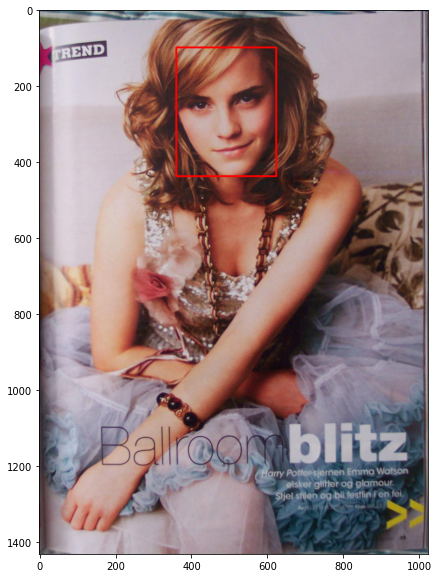

In [ ]:
img = plt.imread("/content/train_dir/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg")
img = cv2.rectangle(img,(361,98),(263+361,339+98),color=(255,0,0),thickness=3)
plt.figure(figsize=(15,10))
plt.imshow(img)

In [ ]:
def create_dataset(filenames,output_filename,train=True):
  filename = None
  content = None
  with open(filenames) as txtfile:
    cls = "face"
    content = txtfile.readlines()
    with open(output_filename+".csv","w") as csvfile:
      csvwriter = csv.writer(csvfile)
      csvwriter.writerow(["filename","width","height", "class", "xmin","ymin","xmax","ymax"])
      for line in content:
        # print(type(line))
        if re.search('jpg$', line):
          # print(line)
          if train:
            filename = "/content/train_dir/WIDER_train/images/" + line[:-1]
          else:
            filename = "/content/val_dir/WIDER_val/images/" +line[:-1]
          # print(filename)
        if len(line.split()) == 1:
          pass
        else:
          bbox = line.split()
          x2 = int(bbox[0])+int(bbox[2])
          y2 = int(bbox[1])+int(bbox[3])
          img = Image.open(filename)
          width,height = img.size
          # print(filename)
          csvwriter.writerow([filename,width,height,cls, bbox[0], bbox[1], x2, y2])

In [ ]:
create_dataset("/content/result/wider_face_split/wider_face_train_bbx_gt.txt","train_dataset",train=True)

In [ ]:
create_dataset("/content/result/wider_face_split/wider_face_val_bbx_gt.txt","val_dataset",train=False)

In [ ]:
from collections import namedtuple, OrderedDict
from models.research.object_detection.utils import dataset_util

def class_text_to_int(row_label):
    if row_label == 'face':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = tf.io.decode_image(encoded_jpg)
    # image = Image.open(encoded_jpg_io)
    height, width,_ = encoded_jpg_io.shape

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example
def createrecord(input_csv,output_record):
  writer = tf.io.TFRecordWriter(output_record)
  path = os.path.join("")
  examples = pd.read_csv(input_csv)
  #
  #
  #
  #running on top 1000 examples only
  #
  #
  #
  # grouped = split(examples, 'filename')
  
  grouped = split(examples.head(1000), 'filename')#edited part
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())

  writer.close()
  output_path = os.path.join(os.getcwd(), output_record)
  print('Successfully created the TFRecords: {}'.format(output_path))

In [ ]:
createrecord("train_dataset.csv","train.record")
createrecord("val_dataset.csv","test.record")

Successfully created the TFRecords: /content/train.record
Successfully created the TFRecords: /content/test.record


**Efficient Net**

In [ ]:
! mkdir /content/models/research/object_detection/training

**Create a label map using .pbtxt as an extension**

ex:-
item {
  id : 1
  name : "face"
}

In [ ]:
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz

# !tar -xf efficientdet_d0_coco17_tpu-32.tar.gz

# !mv efficientdet_d0_coco17_tpu-32 /content/models/research/object_detection

In [ ]:
# !python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/models/research/object_detection/training/efficientdet_d0_coco17_tpu-32/pipeline.config --model_dir=/content/models/research/object_detection/training/ --alsologtostderr


In [ ]:
!cp /content/labelmap.pbtxt /content/models/research/object_detection/training/labelmap.pbtxt

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz

!tar -xf  ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz

!mv ssd_resnet101_v1_fpn_640x640_coco17_tpu-8 /content/models/research/object_detection

--2021-02-02 05:11:12--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386527459 (369M) [application/x-tar]
Saving to: ‘ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet101_v1_fp 100%[===================>] 368.62M   233MB/s    in 1.6s    

2021-02-02 05:11:13 (233 MB/s) - ‘ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [386527459/386527459]



In [ ]:
!cp /content/models/research/object_detection/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/pipeline.config /content/models/research/object_detection/training

**Change configuration on pipeline.config**

1. like making num_classes to one
2. mapping checkpoint path
3. changing batch size depending upon system config.
4. checkpoint type from "classification" to "detection"
5. mapping label txt file
6. mapping train and test records

In [ ]:
 !python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/models/research/object_detection/training/pipeline.config --model_dir=/content/models/research/object_detection/training/ --alsologtostderr

2021-02-02 05:16:25.399742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-02 05:16:29.511433: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-02 05:16:29.512445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-02 05:16:29.516650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-02 05:16:29.517198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-02 05:16:29.517229: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
#!python /content/models/research/object_detection/exporter_main_v2.py -trained_checkpoint_dir =/content/models/research/object_detection/training/ckpt-16 --pipeline_config_path=/content/models/research/object_detection/training/pipeline.config --output_directory=inference_graph
#!python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/models/research/object_detection/training/pipeline.config --alsologtostderr --model_dir=/content/models/research/object_detection/training/

2021-02-02 12:36:10.093950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-02 12:36:12.262566: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-02 12:36:12.263474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-02 12:36:12.267640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-02 12:36:12.268181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-02 12:36:12.268217: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
!mkdir fine_tuned_model

In [ ]:
!cp /content/models/research/object_detection/exporter_main_v2.py /content/models/research/object_detection/training

In [ ]:
!python /content/models/research/object_detection/training/exporter_main_v2.py --input_type=image_tensor --pipeline_config_path=/content/models/research/object_detection/training/pipeline.config --trained_checkpoint_dir=/content/models/research/object_detection/training --output_directory=fine_tuned_model

2021-02-02 12:50:05.885363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-02 12:50:08.076924: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-02 12:50:08.077823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-02 12:50:08.081951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-02 12:50:08.082478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-02 12:50:08.082509: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
# detection_model = tf.saved_model.load()#inference graph path

In [ ]:
import shutil
shutil.make_archive("model", 'zip', "/content/fine_tuned_model")

'/content/model.zip'

In [ ]:
# zipfile.ZipFile("/content/model.zip").extractall("hello")